In [71]:
# librerías
import os
import json
import hashlib
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fase 1: Análisis Exploratorio de Datos (EDA)

### 1.1. Análisis Descriptivo y Versionado Inicial de Datos

In [80]:
# verificamos la ruta de los datos y si se encuentran ahi
data_path = '../data'
excel_files = glob.glob(os.path.join(data_path, '*.xlsx'))
print(f'Archivos encontrados: {len(excel_files)}')
print(excel_files)

Archivos encontrados: 3
['../data\\Totalizadores Planta de Cerveza - 2022_2023.xlsx', '../data\\Totalizadores Planta de Cerveza 2021_2022.xlsx', '../data\\Totalizadores Planta de Cerveza 2023_2024.xlsx']


In [79]:
# aca vamos a leer los archivos y a unificar la hoja 'Consolidado EE' de todos los archivos, que es donde está nuestra variable objetivo 'Frio(Kw)'
target_sheet_name = 'Consolidado EE'
data_frame = []

for file in excel_files:
    try:
        df_sheet = pd.read_excel(file, sheet_name=target_sheet_name)
        data_frame.append(df_sheet)
        print(f'Hoja {target_sheet_name} leída correctamente de {os.path.basename(file)}')
    except Exception as e:
        print(f'Error al leer {target_sheet_name} de {os.path.basename(file)}: {e}')

# concatenamos todos los dataframes en uno solo
if data_frame:
    df_unified_raw = pd.concat(data_frame, ignore_index=True)
    print(f'Dataframe unificado creado con {df_unified_raw.shape[0]} filas y {df_unified_raw.shape[1]} columnas.')
    # mostramos las primeras filas del dataframe unificado
    print('\nPrimeras filas del dataframe unificado:')      
    print(df_unified_raw.head())
    # mostramos la info del dataframe unificado
    print('\nInformación del dataframe unificado:')
    print(df_unified_raw.info())
else:
    print('No se pudieron leer datos de los archivos proporcionados.')
    df_unified_raw = pd.DataFrame()  # aca creamos un dataframe vacio para evitar errores posteriores

# guardamos el dataframe unificado en un archivo csv para facilitar su uso posterior
output_csv_path = os.path.join(data_path, 'df_unified_raw.csv')
df_unified_raw.to_csv(output_csv_path, index=False)
print(f'Dataframe unificado guardado en {output_csv_path}')

Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza - 2022_2023.xlsx
Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza 2021_2022.xlsx
Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza 2023_2024.xlsx
Dataframe unificado creado con 43515 filas y 24 columnas.

Primeras filas del dataframe unificado:
         DIA      HORA  Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  \
0 2022-07-01  02:00:00      1368.76              46.0        101.5   
1 2022-07-01  03:00:00      2765.64              93.0        203.5   
2 2022-07-01  04:00:00      4124.46             141.0        306.0   
3 2022-07-01  05:00:01      5419.31             182.5        401.5   
4 2022-07-01  06:00:01      6673.19             228.0        499.0   

   Cocina (Kw)  Envasado (Kw)  Linea 2 (Kw)  Linea 3 (Kw)  Linea 4 (Kw)  ...  \
0          7.0           12.0         30.01          42.0           0.0  ...   
1         13.0           26.0         59.64     

In [75]:
# ahora procedemos a calcular y guardar el checksum inicial
if not df_unified_raw.empty:
    datetime_col = 'DIA'
    if datetime_col in df_unified_raw.columns:
        df_unified_raw[datetime_col] = pd.to_datetime(df_unified_raw[datetime_col])
        df_unified_raw = df_unified_raw.sort_values(by=datetime_col).reset_index(drop=True)
        print(f'\n Dataframe ordenado por la columna {datetime_col}.')
    else:
        print(f'\n La columna {datetime_col} no existe en el dataframe y por lo tanto no se pudo ordenar.')

    # convertimos a bytes para hashear
    data_bytes = df_unified_raw.to_csv(index=False).encode()
    checksum_initial = hashlib.md5(data_bytes).hexdigest()

    checksum_file_path = os.path.join(data_path, 'checksums.json')
    checksums = {
        'initial_consolidado_ee': checksum_initial
    }

    try:
        with open(checksum_file_path, 'w') as f:
            json.dump(checksums, f, indent=4)
        print(f"\nChecksum inicial '{checksum_initial}' guardado en '{checksum_file_path}'")
    except Exception as e:
        print(f"\nError guardando checksum: {e}")
else:
    print("\nDataFrame vacío, no se calculó el checksum.")


 Dataframe ordenado por la columna DIA.

Checksum inicial '2deec2995b8a8a2cd622190332a4be6a' guardado en '../data\checksums.json'


In [59]:
# pasamos a la agregación a nivel diario, es  decir, solo nos quedamos con la fecha sin la hora para agruapar

df_unified_raw['Fecha_Solo'] = df_unified_raw['DIA'].dt.date

# agrupamos por fecha y tomamos la última observación de cada día
df_daily = df_unified_raw.groupby('Fecha_Solo').last().reset_index()

# por lo tanto la columna 'Fecha_Solo' pasa a ser nuestro índice diario y la pasamos a datetime
df_daily['Fecha_Solo'] = pd.to_datetime(df_daily['Fecha_Solo'])

# la renombramos para mayor claridad
df_daily = df_daily.rename(columns={'Fecha_Solo': 'Fecha'})

# eliminamos las columnas que no aportan información relevante para el análisis diario
columns_to_drop = ['DIA', 'HORA']
df_daily = df_daily.drop(columns=[col for col in columns_to_drop if col in df_daily.columns])

# convertimos dataframe a csv para facilitar su uso posterior
daily_csv_path = os.path.join(data_path, 'consolidado_ee_diario.csv')
try:
    df_daily.to_csv(daily_csv_path, index=False)
    print(f"\nDataFrame diario guardado en '{daily_csv_path}' con {df_daily.shape[0]} filas y {df_daily.shape[1]} columnas.")
except Exception as e:
    print(f"\nError guardando DataFrame diario: {e}")


DataFrame diario guardado en '../data\consolidado_ee_diario.csv' con 1199 filas y 23 columnas.


In [60]:
# dimensiones del dataframe diario
print(f'\nDataframe diario creado con {df_daily.shape[0]} filas y {df_daily.shape[1]} columnas.')
print('\nPrimeras filas del dataframe diario:')
print(df_daily.head())
# info del dataframe diario
print('\nInformación del dataframe diario:')
print(df_daily.info())
print('\nDescripción estadística del dataframe diario:')
print(df_daily.describe().T)


Dataframe diario creado con 1199 filas y 23 columnas.

Primeras filas del dataframe diario:
       Fecha  Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  Cocina (Kw)  \
0 2021-01-01     20016.91           1590.50      1653.50        205.0   
1 2021-01-02     19234.02           2091.00      1965.50        518.0   
2 2021-01-03     12392.11           1139.25      1249.75        120.0   
3 2021-01-04     24853.71           4686.25      2944.75       2418.0   
4 2021-01-05      2201.68            340.50       184.00        226.0   

   Envasado (Kw)  Linea 2 (Kw)  Linea 3 (Kw)  Linea 4 (Kw)  Servicios (Kw)  \
0         6375.0       3649.41        3738.0         257.0         10855.0   
1         5321.0       3055.02        3172.0         220.0         10573.5   
2         3249.0       1670.24        2129.0         162.0          7264.5   
3         1449.0        884.71         469.0           0.0         18771.0   
4          123.0        315.93          55.0           0.0          1491.0   


In [61]:
# valores faltantes
missing_values_daily = df_daily.isna().sum()
missing_percentage_daily = (df_daily.isna().mean() * 100).round(2)
missing_info_daily = pd.DataFrame({'count': missing_values_daily, 'percentage': missing_percentage_daily})
print(missing_info_daily[missing_info_daily['count'] > 0])

            count  percentage
KW CO2        361       30.11
Fecha/Hora    361       30.11
Kw de Frio    361       30.11


#### Conclusiones: 
    -> El dataset tiene 1199 días.
    -> Hay columnas con problemas como Fecha/Hora y Kw de Frio.
    -> Hay un aprox. de 30% de valores faltantes.
    -> Hay valores negativos que no me cierran.
    -> Se pueden observar indicios de outliers en varias columnas incluyendo la objetivo como Frio(Kw)

### 1.2. Análisis Temporal

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos (opcional)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6) # Ajustar tamaño

# --- Graficar la evolución del target diario ---
plt.figure() # Crear nueva figura
plt.plot(daily['Fecha'], daily['Frio (Kw)'], label='Consumo Diario Frio (kW)')
plt.title('Evolución del Consumo Diario de Frío (kW) - 2021-2024')
plt.xlabel('Fecha')
plt.ylabel('Frio (kW) - Total Diario')
plt.legend()
plt.show()

KeyError: 'Fecha'

<Figure size 1500x600 with 0 Axes>

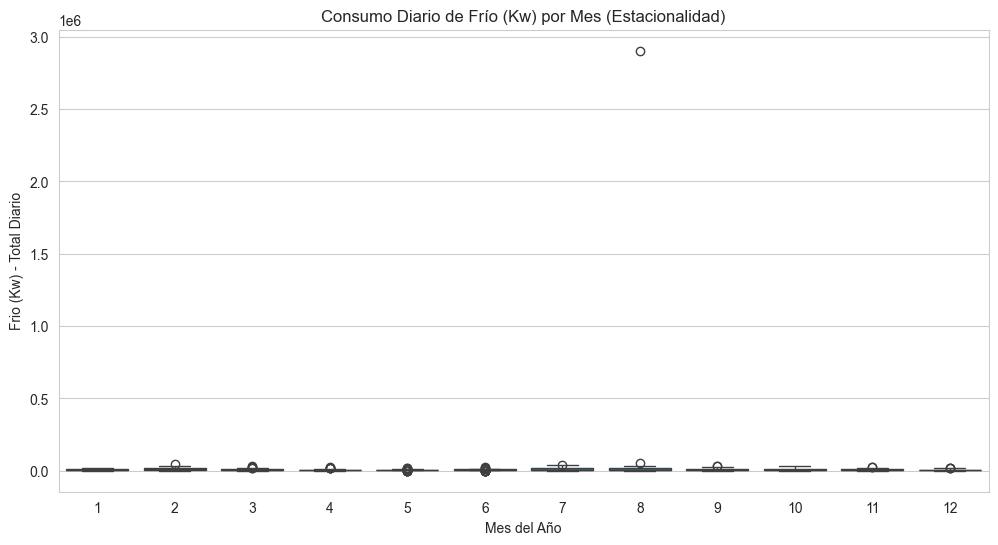


Revisar el primer gráfico (Evolución Temporal) para observar patrones anuales.


In [49]:
# --- Analizar Estacionalidad Mensual con Boxplots ---
# Crear columnas de Mes y Año para agrupar
df_daily['Mes'] = df_daily['Fecha'].dt.month
df_daily['Año'] = df_daily['Fecha'].dt.year

plt.figure(figsize=(12, 6))
sns.boxplot(x='Mes', y='Frio (Kw)', data=df_daily)
plt.title('Consumo Diario de Frío (Kw) por Mes (Estacionalidad)')
plt.xlabel('Mes del Año')
plt.ylabel('Frio (Kw) - Total Diario')
plt.show()

# --- Análisis Anual (Visual en el primer gráfico) ---
print("\nRevisar el primer gráfico (Evolución Temporal) para observar patrones anuales.")
# Opcional: Podríamos calcular promedios anuales si queremos cuantificarlo
# print(df_diario.groupby('Año')['Frio (kW)'].mean())


--- Consumo Promedio Diario por Día de la Semana ---
Nombre_Dia_Semana
Lunes        44867.713450
Martes        8404.514620
Miércoles    10129.742690
Jueves       26730.732558
Viernes       8722.204678
Sábado        8207.703488
Domingo       9334.116959
Name: Frio (Kw), dtype: float64


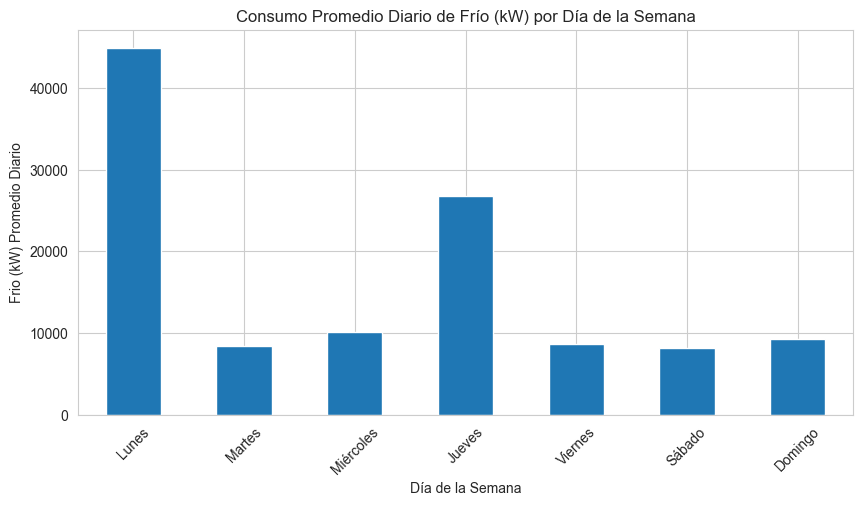

In [63]:
# --- Analizar Patrones Semanales ---
# Crear columna para el día de la semana (0=Lunes, 6=Domingo)
df_daily['Dia_Semana'] = df_daily['Fecha'].dt.dayofweek
# Mapear a nombres para mejor visualización (opcional)
day_map = {0:'Lunes', 1:'Martes', 2:'Miércoles', 3:'Jueves', 4:'Viernes', 5:'Sábado', 6:'Domingo'}
df_daily['Nombre_Dia_Semana'] = df_daily['Dia_Semana'].map(day_map)

# Calcular consumo promedio por día de la semana
consumo_promedio_semanal = df_daily.groupby('Nombre_Dia_Semana')['Frio (Kw)'].mean().reindex(day_map.values())

print("\n--- Consumo Promedio Diario por Día de la Semana ---")
print(consumo_promedio_semanal)

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 5))
consumo_promedio_semanal.plot(kind='bar')
plt.title('Consumo Promedio Diario de Frío (kW) por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Frio (kW) Promedio Diario')
plt.xticks(rotation=45)
plt.show()

In [65]:
# --- Correlación Día Semana vs Consumo ---
# Usamos la columna numérica 'Dia_Semana' (0-6)
correlacion_dia_semana = df_daily['Dia_Semana'].corr(df_daily['Frio (Kw)'])

print(f"\n--- Correlación entre Día de la Semana (numérico 0-6) y Frio (kW) ---")
print(f"Coeficiente de correlación de Pearson: {correlacion_dia_semana:.3f}")
# Nota: Una correlación baja aquí no significa que no haya patrón semanal,
# solo que la relación podría no ser puramente lineal de Lunes a Domingo.
# El gráfico de barras anterior es más informativo para patrones no lineales.


--- Correlación entre Día de la Semana (numérico 0-6) y Frio (kW) ---
Coeficiente de correlación de Pearson: -0.039
